### Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

%matplotlib inline

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Qtd Digits:  1797


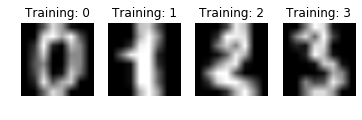

In [2]:
digits = load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='bilinear')
    plt.title('Training: %i' % label)

n_samples = len(digits.images)
print('Qtd Digits: ', n_samples)

# Data preparation
# Flatten
X = digits.images.reshape((n_samples, -1))
# Normalization, from 0 to 1
X = X / 255.
# Targets
y = digits.target
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [150]:
import math
import numpy as np
import pandas as pd


class Layer:

    def __init__(self):
        self._name = 0

    def init(self, name):
        self._name = name

    def __str__(self):
        return f'Layer: {self._name}'
    
    def __repr__(self):
        return f'Layer: {self._name}'


class Dense(Layer):

    def __init__(self, inputs=1, outputs=1, activation='sigmoid'):
        super().__init__()
        self.W = np.random.rand(inputs, outputs) * np.sqrt(2 / (outputs + inputs))
        self.B = np.zeros((1, outputs))
        self.A = np.zeros((inputs, self.W.shape[0]))
        
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        elif activation == 'relu':
            self._activation = self._relu
        elif activation == 'tahn':
            self._activation = self._tahn
        elif activation == 'softmax':
            self._activation = self._softmax

    def _sigmoid(self, Z, deriv=False):
        if deriv:
            return Z * (1 - Z)
        return 1. / (1 + np.exp(-Z))
    
    def _relu(self, Z, deriv=False):
        if deriv:
            return 1. * (Z > 0)
        return np.maximum(0, Z)

    def _tahn(self, Z, deriv=False):
        K = np.tanh(Z)
        if deriv:
            return 1 - (K**2)
        return K

    def _softmax(self, Z, deriv=False):
        y = np.exp(Z - Z.max())
        return y / np.sum(y, axis=1, keepdims=True)

    def forward(self, Z):
        self.A = self._activation(Z.dot(self.W) + self.B)
        return self.A

    def gradient(self, error):
        # Clipping to avoid exploding gradients
        return np.clip(error * self._activation(self.A, deriv=True), -1.5, 1.5)


class NeuralNetwork:

    def __init__(self, layers, X, y, tol=1e-4, loss='mse'):
        # That is why we seed the generator - to make sure that we always get the same random numbers.
        np.random.seed(0)
        
        # Naming the layers (indexing)
        self._total_layers = len(layers)
        for k in range(self._total_layers):
            layers[k].init(k)

        # Initialization
        self._layers = layers
        self._X = X
        self._y = y
        
        self._tol = tol
        self._loss = self._mse
        if loss == 'cross_entropy':
            self._loss = self._cross_entropy
        self._y = self._one_hot_encode(self._y)
        
        self._total_samples = 1. / self._y.shape[0]
        self._mem_weights = {}

    def predict(self, Z):
        return np.argmax(self._forward(Z), axis=1)

    def _one_hot_encode(self, y):
        return pd.get_dummies(y).values
    
    def _mse(self, y, Z):
        return np.sum((Z-y)**2) * self._total_samples

    def _cross_entropy(self, y, Z):
        Z = Z.clip(min=1e-12)
        return -np.sum(y * np.log(Z)) * self._total_samples
        # return -(np.sum(y * np.log(err) + (1-y) * np.log(1-err))) * self._total_samples
    
    def _forward(self, Z):
        for i, layer in enumerate(self._layers):
            Z = layer.forward(Z)
        return Z

    def _backward(self, X, E_prev):
        # First Layer
        last_layer = self._layers[-1]
        delta = E_prev
        self._mem_weights[f'{last_layer}'] = (
            self._layers[-2].A.T.dot(delta),  # dW 
            np.sum(delta, axis=0)  # dB
        )

        # Hidden Layers
        k = len(self._layers)-2
        for layer in reversed(self._layers[1:len(self._layers)-1]):
            E_prev = E_prev.dot(last_layer.W.T)
            last_layer = layer
            delta = last_layer.gradient(E_prev)
            self._mem_weights[f'{last_layer}'] = (
                self._layers[(k-1)].A.T.dot(delta),  # dW 
                np.sum(delta, axis=0)  # dB
            )
            k -= 1

        # Last Layer
        E_prev = E_prev.dot(last_layer.W.T)
        last_layer = self._layers[0]
        delta = last_layer.gradient(E_prev)
        self._mem_weights[f'{last_layer}'] = (
            X.T.dot(delta),  # dW
            np.sum(delta, axis=0)  # dB
        )

    def _update_weights(self, m, lr):
        for layer in reversed(self._layers):
            W, B = self._mem_weights[f'{layer}']
            layer.W -= lr * (W * m)
            layer.B -= lr * (B * m)

    def _shuffle(self, X, y):
        permutation = np.random.permutation(X.shape[0])
        return X[permutation], y[permutation]

    def train(self, epochs=1500, lr=1e-3, batch_size=32):
        error_step = []
        total_expected_error = 0

        # Batch size iteration
        mb = math.ceil(self._X.shape[0] / batch_size)
        m = 1. / batch_size

        iter_n = 0
        for ep, epoch in enumerate(range(epochs)):
            # Shuffle dataset in each epoch
            X, y = self._shuffle(self._X.copy(), self._y.copy())

            # Mini batch
            total_error = 0
            k = 0
            for _ in range(mb):
                # Mini batch crop
                ini, end = k * batch_size, (k + 1) * batch_size
                batch_X, batch_y = X[ini:end, :], y[ini:end, :]
                k += 1

                # Forward
                Z = self._forward(batch_X)
                
                # Loss
                err = Z - batch_y  # error
                
                # Backward / Backprop
                self._backward(batch_X, err)

                # Update weights and bias
                self._update_weights(m, lr)

                # Cost
                total_error += self._loss(batch_y, Z)
            
            if np.abs(total_expected_error-total_error) < self._tol:
                iter_n += 1
            # Early stop, no improvements after 10 iterations
            if iter_n >= 10:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)
        return np.array(error_step)

In [151]:
# from src.nn import Dense, NeuralNetwork

final_error = []
better_acc = 0

layers = (
    Dense(inputs=64, outputs=100, activation='relu'),
    Dense(inputs=100, outputs=200, activation='relu'), 
    Dense(inputs=200, outputs=10, activation='softmax'), 
)

md = NeuralNetwork(layers, X_train.copy(), y_train.copy(), loss='cross_entropy')
error = md.train(epochs=145, lr=1e-1)

y_pred = md.predict(X_test.copy())

acc = np.round((np.sum(y_pred == y_test) / len(y_test)) * 100, 2)
if acc > better_acc:
    better_acc = acc
final_error = error
print(f'Acurácia: {acc}%')

print("Classification report for classifier \n%s\n"
      % (classification_report(y_test, y_pred)))
print('-' * 20)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_pred))

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

ValueError: operands could not be broadcast together with shapes (100,200) (100,10) (100,200) 

Acurácia: 96.11%
--------------------
Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=1500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       0.84      0.94      0.89        52
           2       0.98      0.91      0.94        53
           3       1.00      0.96      0.98        54
           4       0.91      1.00      0.95        48
           5       0.95      0.98      0.97        57
           6       1.00      0.98      0.99        60
           7       0.98      0.96      0.97  

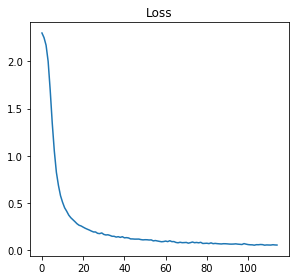

In [94]:
classifier = MLPClassifier(
    max_iter=1500,
    solver='sgd',
    batch_size=32,
    shuffle=True,
    learning_rate_init=1e-1,
    random_state=0
)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print(f'Acurácia: {np.round(classifier.score(X_test, y_test) * 100, 2)}%')
print('-' * 20)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, classification_report(y_test, predicted)))
print('-' * 20)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, predicted))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f'Loss')
plt.plot(range(classifier.n_iter_), classifier.loss_curve_)
plt.tight_layout()
plt.show()